# The Elbow Method

Description

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler')
    .as_posix()
)

os.chdir(path)
sys.path.append(path)

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots

from constant import SETTINGS, TUNING
from datatype.dataset import Dataset
from datatype.scorer import (
    CalinskiHarabaszScore, 
    DaviesBouldinIndex,
    PartitionCoefficient,
    PartitionEntropyCoefficient,
    SilhouetteScore,
    SumOfSquaredErrors,
    XieBeniIndex
)
from datatype.settings import Settings
from datatype.voronoi import Builder, VoronoiFCM
from fcmeans import FCM

In [ ]:
plt.style.use('science')

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [5]:
dataframe = dataframe.drop(
    ['fcm_label_2d'],
    axis=1,
    errors='ignore'
)

In [6]:
x = np.array(
    [
        dataframe.umap_x_2d,
        dataframe.umap_y_2d
    ]
).transpose()

In [7]:
csv = TUNING.joinpath('search.csv')
search = pd.read_csv(csv)

search = search.sort_values(
    ascending=True, 
    by=['id']
)

In [8]:
search.head(5)

,id,parameter,calinski_harabasz_score,davies_bouldin_index,partition_coefficient,partition_entropy_coefficient,silhouette_score,sum_of_squared_errors,xie_beni_index
0,1,"{'m': 1.1, 'max_iter': 100, 'n_clusters': 3, 'random_state': 42}",12773.289225,0.810163,0.323898,0.022378,0.425943,206323.951821,0.179762
1,2,"{'m': 1.1, 'max_iter': 100, 'n_clusters': 4, 'random_state': 42}",14838.804017,0.790335,0.242888,0.017184,0.426971,138480.033672,0.194018
2,3,"{'m': 1.1, 'max_iter': 100, 'n_clusters': 5, 'random_state': 42}",15999.112643,0.778250,0.193764,0.015096,0.424254,103352.044937,0.180846
3,4,"{'m': 1.1, 'max_iter': 100, 'n_clusters': 6, 'random_state': 42}",15863.093144,0.788184,0.161091,0.013719,0.417381,86205.707235,0.207527
4,5,"{'m': 1.1, 'max_iter': 100, 'n_clusters': 7, 'random_state': 42}",16006.610286,0.785898,0.138040,0.011921,0.402770,72956.006191,0.191691


In [9]:
metrics = [
    CalinskiHarabaszScore, 
    DaviesBouldinIndex,
    PartitionCoefficient,
    PartitionEntropyCoefficient,
    SilhouetteScore,
    SumOfSquaredErrors,
    XieBeniIndex
]

Calinski-Harabasz Score: {'m': 1.7000000000000006, 'max_iter': 100, 'n_clusters': 38, 'random_state': 42}, 24647.936091478838


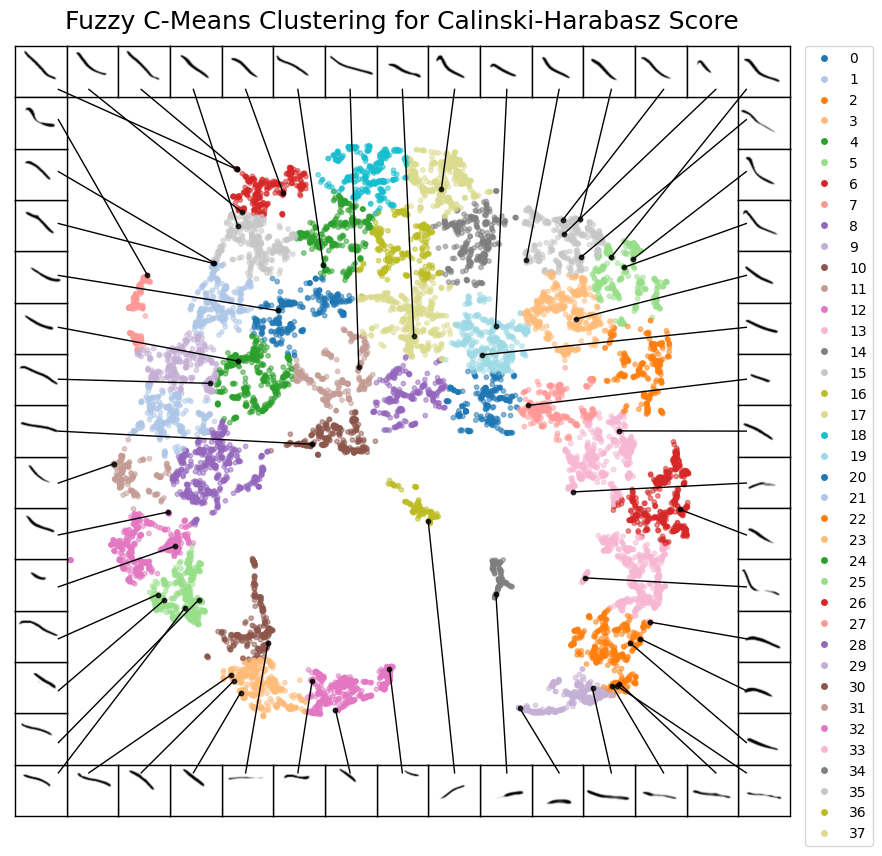

Davies-Bouldin Index: {'m': 1.1, 'max_iter': 400, 'n_clusters': 12, 'random_state': 42}, 0.7017193056705896


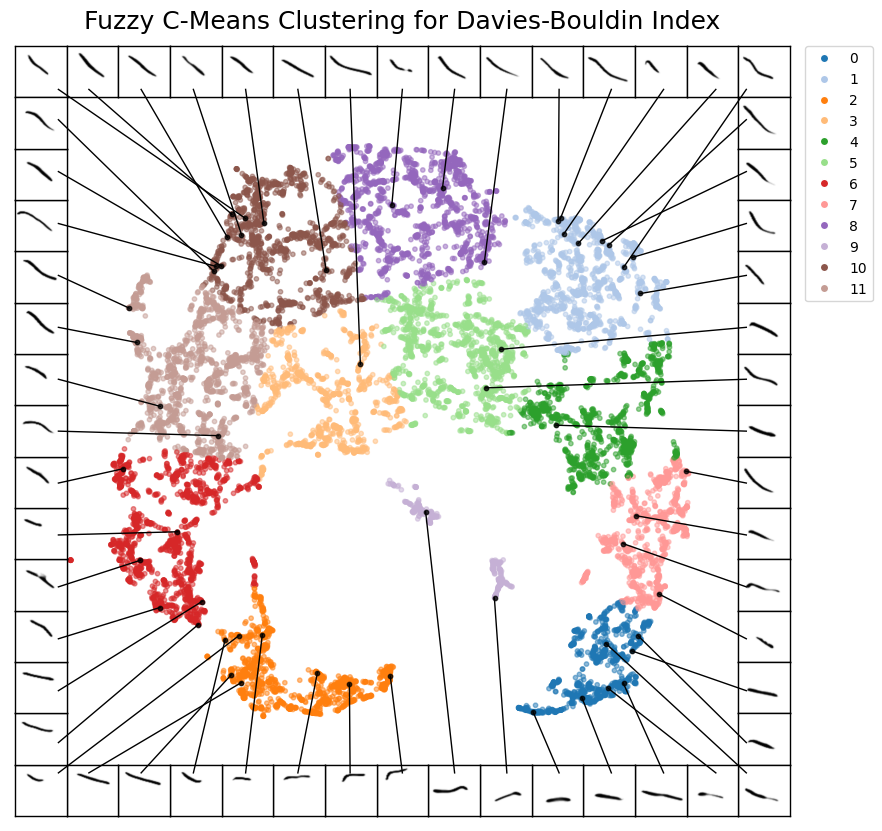

Partition Coefficient: {'m': 1.1, 'max_iter': 400, 'n_clusters': 3, 'random_state': 42}, 0.3238980216810104


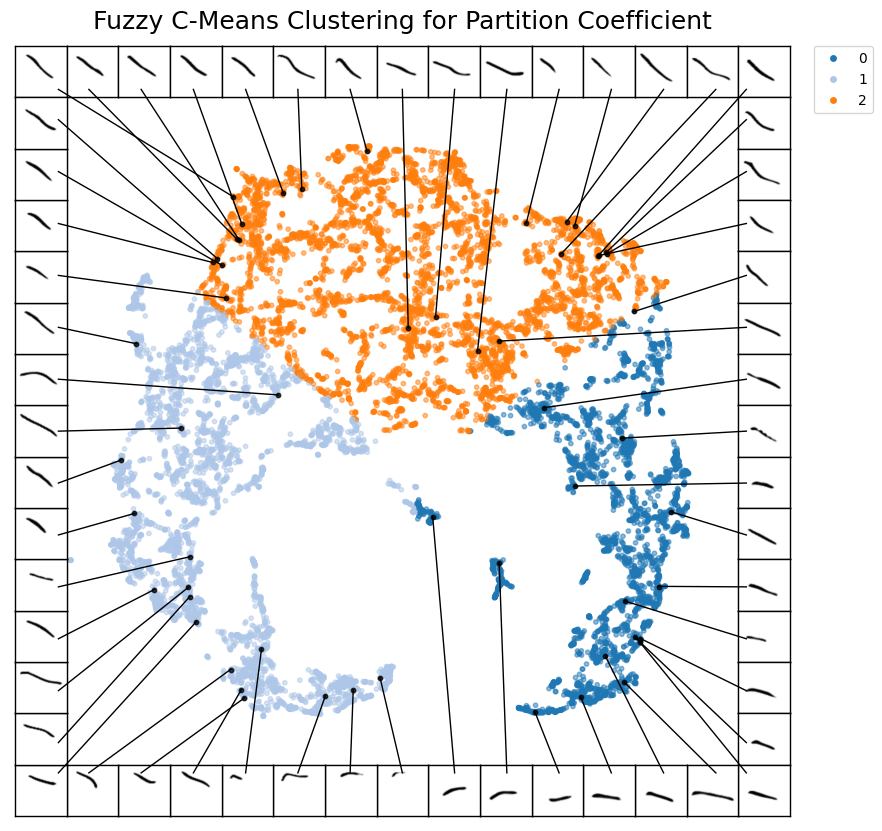

Partition Entropy Coefficient: {'m': 1.1, 'max_iter': 500, 'n_clusters': 35, 'random_state': 42}, 0.0014802624476116


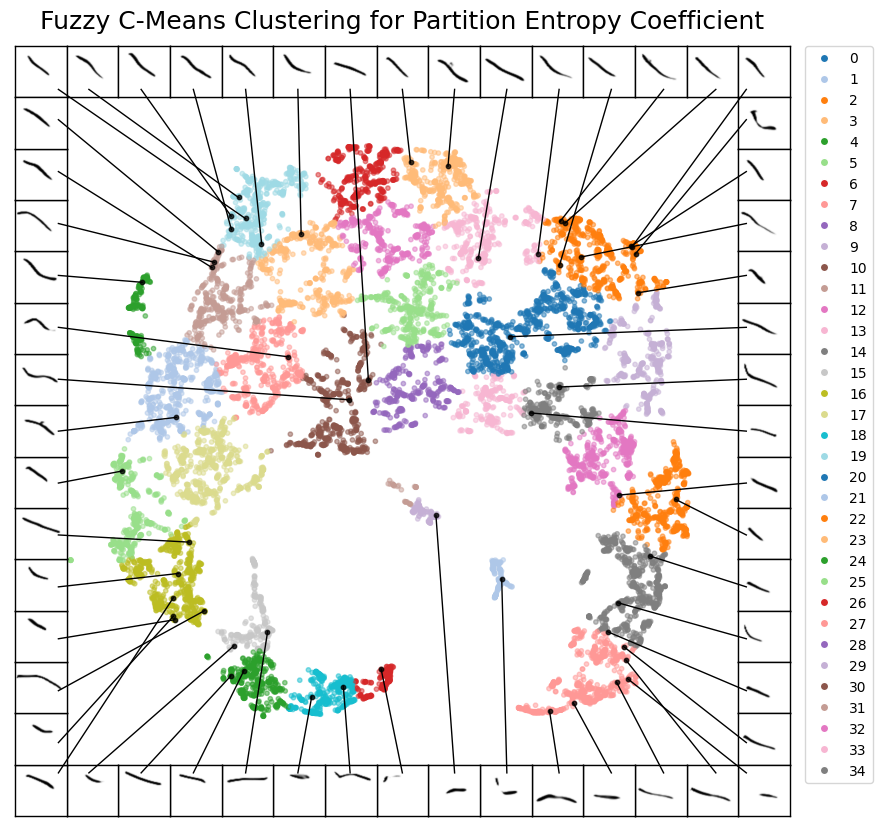

Silhouette Score: {'m': 1.5000000000000004, 'max_iter': 400, 'n_clusters': 38, 'random_state': 42}, 0.4499815702438354


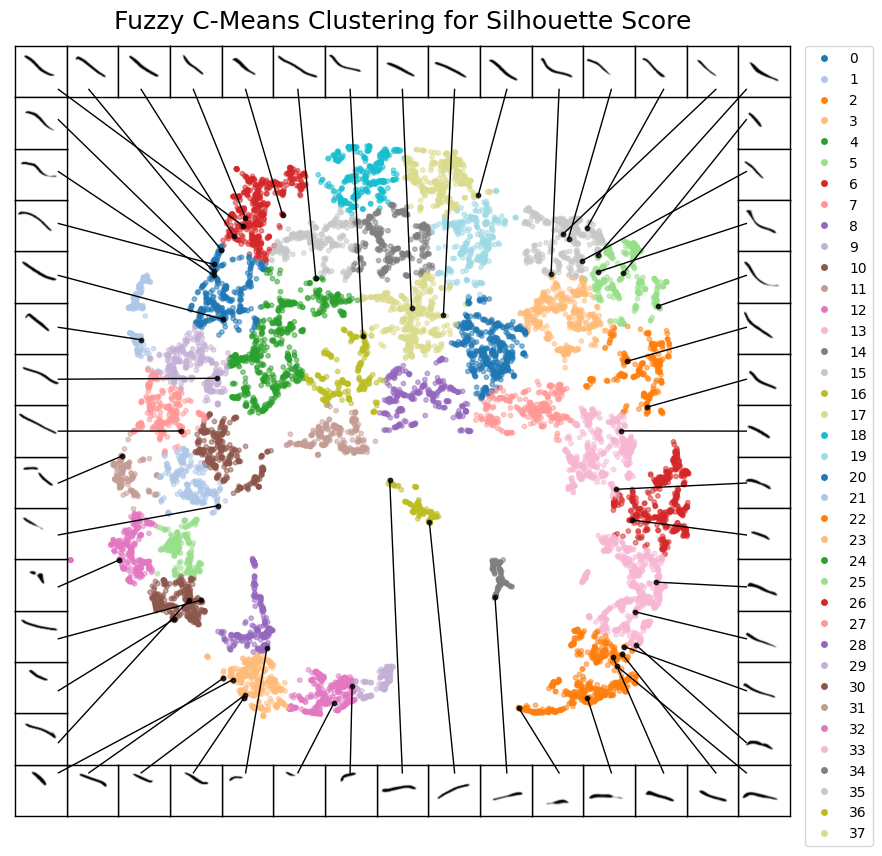

Sum Of Squared Errors: {'m': 2.9000000000000017, 'max_iter': 1000, 'n_clusters': 38, 'random_state': 42}, 355.6698947341334


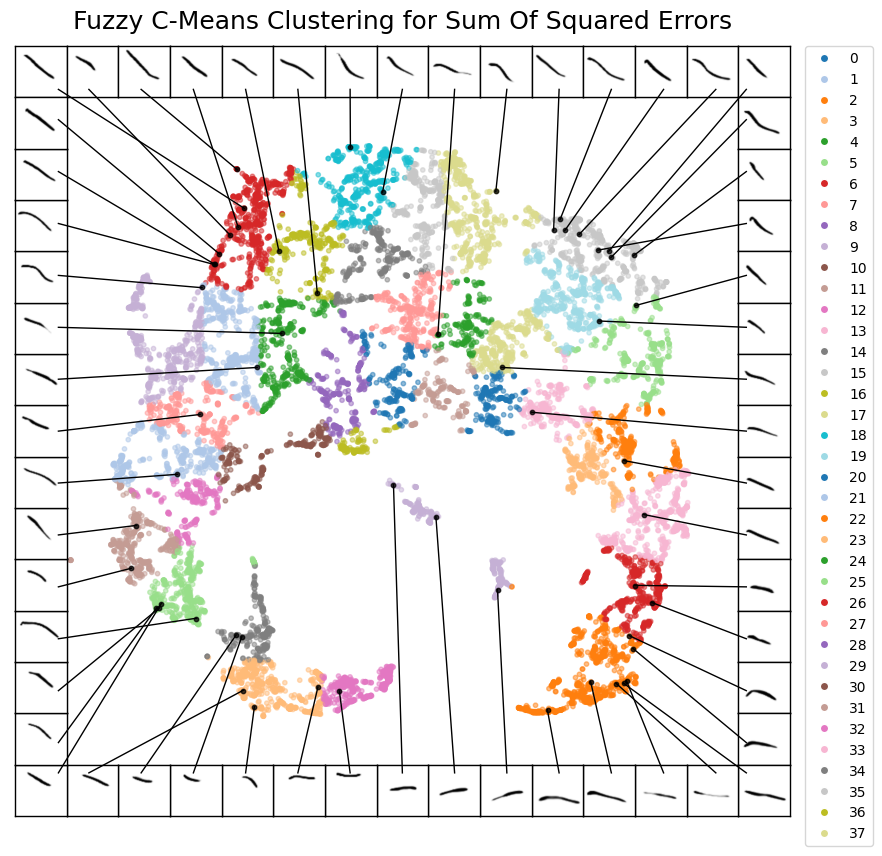

Xie-Beni Index: {'m': 2.9000000000000017, 'max_iter': 200, 'n_clusters': 14, 'random_state': 42}, 0.0203097359820024


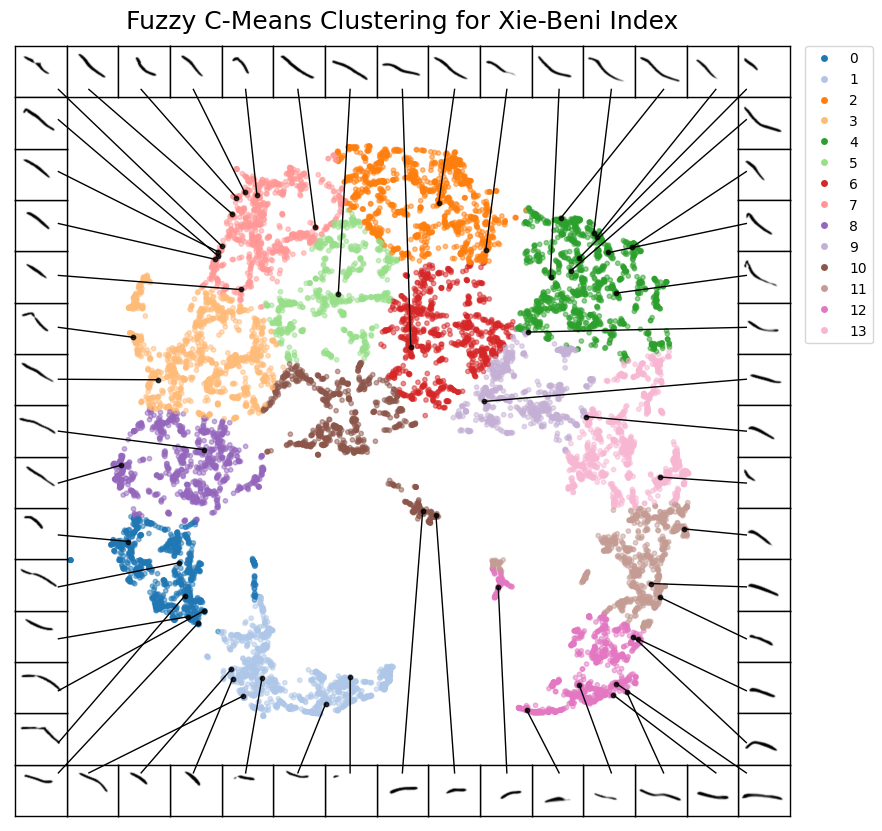

In [10]:
for metric in metrics:
    instance = metric()
    
    name = repr(instance)
    ylabel = str(instance)

    column = ['parameter', name]
    
    ascending = not metric.maximize
    
    search = search.sort_values(
        ascending=ascending, 
        by=[name]
    )

    parameter, score = search.iloc[0][column]
    parameter = ast.literal_eval(parameter)
    
    print(f"{ylabel}: {parameter}, {score}")
    
    fcm = FCM(**parameter)
    fcm.fit(x)

    label = fcm.predict(x)
    dataframe['fcm_label_2d'] = label

    path = SETTINGS.joinpath('voronoi.json')
    settings = Settings.from_file(path)
    settings.name = ylabel

    unique = dataframe.fcm_label_2d.unique()

    by = ['duration']

    ascending = [False]

    temporary = dataframe.sort_values(
        ascending=ascending,
        by=by
    )

    coordinates = [
        temporary.umap_x_2d,
        temporary.umap_y_2d
    ]

    embedding = np.column_stack(coordinates)

    spectrogram = temporary.filter_array.to_numpy()
    label = temporary.fcm_label_2d.to_numpy()

    builder = Builder(
        builder=builder,
        embedding=embedding,
        label=label,
        spectrogram=~spectrogram,
        settings=settings,
        unique=unique
    )

    voronoi = VoronoiFCM(builder=builder)

    component = voronoi.build()

    voronoi.show()
    
    figure = component.get('figure')

    filename = f"voronoi_{name}.png"

    voronoi.save(
        figure=figure,
        filename=filename
    )